In [ ]:
pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 677 kB/s 
     |████████████████████████████████| 9.9 MB 32.5 MB/s 
     |████████████████████████████████| 11.2 MB 54.5 MB/s 
     |████████████████████████████████| 61 kB 8.6 MB/s 
     |████████████████████████████████| 15.7 MB 33.6 MB/s 
     |████████████████████████████████| 944 kB 33.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    

In [ ]:
pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# The Image Classification Dataset

In [ ]:
%matplotlib inline
import torch
import random 
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()
# specifices the matplotlib package to output the svg figures for sharper images

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Reading the Dataset

In [ ]:
trans = transforms.ToTensor()
# 입력데이터가 numpy 혹은 PIL 이미지 형식인 경우 tensor로 바꾸어줌
mnist_train = torchvision.datasets.KMNIST(root = "../data", train = True, 
                                                transform = trans, download = True)
mnist_test = torchvision.datasets.KMNIST(root = "../data", train = False, 
                                               transform = trans, download = True)

In [ ]:
len(mnist_train), len(mnist_test)
# train data는 60000개의 image로 이루어져있고 test data는 10000개의 image로 이루어져있음
# 각 10개의 category에 6000개, 1000개씩 image 구성

(60000, 10000)

In [ ]:
mnist_train[0][0].shape
# channel = 1 => 흑백 이미지
# 28 x 28 pixel

torch.Size([1, 28, 28])

In [ ]:
def get_KMNIST_labels(labels):
  """Return text labels for the KMNIST dataset."""
  text_labels = ['o', 'ki', 'su', 'tsu', 'na',
                 'ha', 'ma', 'ya', 're', 'wo']
  return [text_labels[int(i)] for i in labels]
# 현재 숫자로 라벨링 되어있는 라벨을 상응하는 텍스트 라벨로 바꾸어줌

In [ ]:
def show_images(imgs, num_rows, num_cols, titles = None, scale = 1.5):
  """Plot a list of images"""
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize = figsize)
  # subplot num_rows * num_cols의 형태와 개수로
  axes = axes.flatten()
  # 1차원 배열로 평탄화해주는 함수
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    # zip을 이용해서 axes, imgs를 각 index 별로 짝지어주고, enumerate를 이용해서 그걸 
    # 다시 0부터 indexing
    if torch.is_tensor(img):
      # Tensor Image면
      ax.imshow(img.numpy())
      # 데이터를 이미지로 보여주는 함수 imshow
      # tensor image의 경우 numpy 배열로 바꾸어줘야함
    else:
      # Tensor Image가 아니라 PIL Image면
      ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    # 본디 x축, y축을 안 보이게 숨겨주는 함수
    # False이기 때문에 숨기지 않음
    if titles:
      ax.set_title(titles[i])
  return(axes)

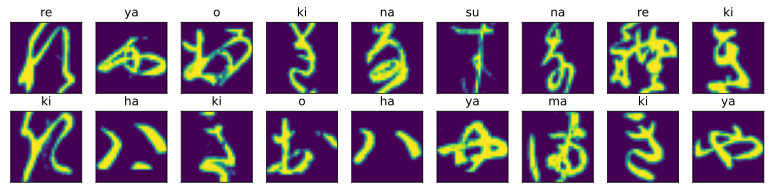

In [ ]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size = 18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles = get_KMNIST_labels(y));
# X의 채널의 수를 batch_size와 맞춰주어야함. 18개의 image를 불러오기 때문에 row * column도 18이어야함
# get_KMNIST_labels(y)를 이용해서 labeling 해주었음

## Reading a Minibatch

In [ ]:
batch_size = 256

def get_dataloader_workers(): 
  """Use 4 processes to read the data."""
  return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle = True,
                             num_workers = get_dataloader_workers())
# DataLoader는 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌈
# 딥러닝 학습을 좀 더 빠르게 진행하는데 사용되는 GPU는 기본적으로 CPU의 컨트롤을 받기 때문에 
# CPU의 성능도 GPU의 속도에 지대한 영향을 줄 수 있음
# num_workers는 학습 도중 CPU의 작업을 몇 개의 코어를 사용해서 진행할지에 대한 설정 파라미터
# 사용 가능한 코어의 수를 확인해보고 다른 작업에 영향을 주지 않을 정도의 숫자로 진행해주는 것이 좋음

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Putting All Things Together

In [ ]:
def load_data_KMNIST(batch_size, resize = None):
  """Download the KMNIST dataset and then load it into memory."""
  trans = [transforms.ToTensor()]
  # 입력데이터가 numpy 혹은 PIL 이미지 형식인 경우 tensor로 바꾸어줌
  # []를 이용해서 list로 바꿔줌
  if resize:
    trans.insert(0, transforms.Resize(resize))
    # Resize: input image를 주어진 사이즈로 resize해줌
    # trans의 0번째 index에 transforms.Resize(resize) insert하고 그 이후 element들은
    # shifted right
  trans = transforms.Compose(trans)
  # 여러개의 transform 단계를 하나로 묶음
  mnist_train = torchvision.datasets.KMNIST(root = "../data", train = True, 
                                                transform = trans, download = True)
  mnist_test = torchvision.datasets.KMNIST(root = "../data", train = False, 
                                               transform = trans, download = True)
  return (data.DataLoader(mnist_train, batch_size, shuffle = True, 
                          num_workers = get_dataloader_workers()),
          data.DataLoader(mnist_test, batch_size, shuffle = False, 
                          num_workers = get_dataloader_workers()))
  # 샘플에 쉽게 접근할 수 있도록 iterable(순회 가능한 객체)로 감쌈
  # test data는 shuffle을 안하는 건 다음 코드를 보면 batch size가 32인데 
  # test data는 shape이 32뿐임. 그래서 shuffle의 의미가 없기 때문에 안하는듯 싶음

In [ ]:
train_iter, test_iter = load_data_KMNIST(32, resize = 64)
for X, y in train_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# Implementation of Softmax Regression from Scratch

In [ ]:
import torch
from IPython import display
from d2l import torch as d2l

In [ ]:
batch_size = 256
train_iter, test_iter = load_data_KMNIST(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Initializing Model Parameters

In [ ]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size = (num_inputs, num_outputs), requires_grad = True)
b = torch.zeros(num_outputs, requires_grad = True)

## Defining the Softmax Operation

In [ ]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
print(X.sum(0), X.sum(0, keepdim = True), X.sum(1, keepdim = True))
print(X.sum(0).shape, X.sum(0, keepdim = True).shape, X.sum(1, keepdim = True).shape)
# 0하면 rowwise 계산해서 column끼리 더함
# 1하면 columnwise 계산해서 row끼리 더함

tensor([5., 7., 9.]) tensor([[5., 7., 9.]]) tensor([[ 6.],
        [15.]])
torch.Size([3]) torch.Size([1, 3]) torch.Size([2, 1])


In [ ]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdim = True)
  # columnwise 계산해서 row(example, record)끼리 더함
  return X_exp / partition

In [ ]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2534, 0.3631, 0.1111, 0.1571, 0.1152],
         [0.0749, 0.8272, 0.0198, 0.0643, 0.0138]]), tensor([1., 1.]))

## Defining the Model

In [ ]:
def net(X):
  return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)
# 오리지널 이미지를 W의 shape(784 = 28 * 28 * 10 = # of labels)로 reshape해줌

In [ ]:
def cross_entropy(y_hat, y):
  return -torch.log(y_hat[range(len(y_hat)), y])

In [ ]:
def accuracy(y_hat, y):
  """Compute the number of correct predictions"""
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
  # len returns the size along the first axis(행의 개수)
  # y_hat.shape[1] = 열의 개수
  # 행과 열이 한 개가 넘는다면
    y_hat = y_hat.argmax(axis = 1)
    # 각 row에서 최대값인 값의 index를 y_hat에 저장
  cmp = y_hat.type(y.dtype) == y
  # ==는 data type에 민감하기 때문에 y_hat의 data type을 y와 동일하게 만들어줌
  # cmp에는 y_hat == y의 여부에 따라 false, true값이 저장됨
  return float(cmp.type(y.dtype).sum())
  # cmp.type(y.dtype)을 통해서 cmp에 할당돼있던 true, false가 각각 0과 1로 바뀜
  # 이를 모두 합해 true의 개수를 return함
  # 애초에 len(y)까지 나누면 안되나?

In [ ]:
class Accumulator:
  """For accumulating sums over `n` variables."""
  def __init__(self, n):
    self.data = [0.0] * n
    # n개의 0.0을 element로 지니는 list self.data
  def add(self, *args):
  # *args는 Keyword value를 제외한 모든 것을 인자로 받을 수 있음
  # 인자가 몇개인지 불분명할 때 사용
    self.data = [a + float(b) for a, b in zip(self.data, args)]
    # data에 인자를 float으로 바꾸어 더해줌
  def reset(self):
    self.data = [0.0] * len(self.data)
    # 다시 0.0으로 값들 초기화
  def __getitem__(self, idx):
    return self.data[idx]
    # 해당 index에 있는 데이터 반환

In [ ]:
def evaluate_accuracy(net, data_iter):
# data_iter을 통해 접근 가능해진 data iterator와 net을 이용해 accuracy 계산
  """Compute the accuracy for a model on a dataset."""
  if isinstance(net, torch.nn.Module):
  # isinstance(확인하고자 하는 값, 확안하고자 하는 타입)
  # net이 torch.nn.Module 타입이면 true
    net.eval()
    # .train()이 있고 .eval()이 있는데, 각 수행 과정에서 사용되지 않을 layer들을 꺼주는 
    # 역할을 한다고 한다.
  metric = Accumulator(2)
  # [0.0, 0.0]이 생성됨

  with torch.no_grad():
    for X, y in data_iter:
      metric.add(accuracy(net(X), y), y.numel())
      # numel input tensor의 총 element수
      # metric[0]에는 y_hat과 y 중 일치하는 개수를
      # metric[1]에는 y의 element 수(len(y)와 비슷하나 다차원 배열의 경우 len(y)는 
      # first axis의 size를 반환하기 때문에 numel()을 사용한듯
  return metric[0] / metric[1]

In [ ]:
evaluate_accuracy(net, test_iter)
# train 이전에는 accuracy 형편없음

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.1206

## Training

In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater):
  """The training loop defined in Chapter 3."""
  if isinstance(net, torch.nn.Module):
    net.train()
    #Set the model to training mode
  metric = Accumulator(3)
  # Sum of training loss, sum of traininng accuracy, no.of examples
  for X, y in train_iter:
    # Compute gradients and update parameters
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):
      # updater가 torch.optim.Optimizer type이라면
      # Using PyTorch in-built optimizer & loss criterion
      updater.zero_grad()
      l.mean().backward()
      updater.step()
    else:
      # Using custom built optimizier & loss criterion
      l.sum().backward()
      updater(X.shape[0])
    metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # metric[0]에는 float(l.sum())을, metric[1]에는 y_hat과 y의 일치 개수를
    # metric[2]에는 y.numel(), y의 총 원소 개수를 더해줌
  return metric[0] / metric[2], metric[1] / metric[2]
  # train loss와 training accuracy를 return

In [ ]:
class Animator:
  """For plotting data in animation."""
  def __init__(self, xlabel = None, ylabel = None, legend = None, xlim = None,
               ylim = None, xscale = 'linear', yscale = 'linear',
               fmts = ('-', 'm--', 'g-.', 'r:'), nrows = 1, ncols = 1,
               figsize = (3.5, 2.5)):
    # Incrementally(점진적으로) plot multiple lines
    if legend is None:
      legend = []
      # legend가 None이면 legend는 비어있음
    d2l.use_svg_display()
    # specifices the matplotlib package to output the svg figures for sharper images
    self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize = figsize)
    # figure에는 plot 저장 axes에는 축 배열
    if nrows * ncols == 1:
      self.axes = [self.axes, ]
    self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel,
                                            xlim, ylim, xscale, yscale, legend)
    # using lambda function to capture arguments
    self.X, self.Y, self.fmts = None, None, fmts
  
  def add(self, x, y):
    if not hasattr(y, "__len__"):
    # hasattr는 y에 __len__이라는 멤버가 있는지 확인해줌
      y = [y]
      # 없으면 y를 list로 만들어 y에 할당
    n = len(y)
    if not hasattr(x, "__len__"):
      x = [x] * n
      # x에 __len__이라는 멤버가 없으면 x에 x를 n(len(y)개 원소로 갖는 list 생성해서 할당
    if not self.X:
      # self.X가 없으면
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a, b) in enumerate(zip(x, y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    # 현재 좌표축을 지움
    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x, y ,fmt)
      # fmt는 포인트의 크기를 결정 짓는 매개변수인듯
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait = True)
    # 그림을 매번 쓰고 지우는 함수 wait = False를 하면 이미지가 렌더링되기도 전에 지워버려서
    # 이미지를 볼 수 없음

In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
  """Train a model (defined in Chapter 3)."""
  animator = Animator(xlabel = 'epoch', xlim = [1, num_epochs], ylim = [0.3, 0.9],
                      legend = ['train loss', 'train acc', 'test acc'])
  for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
    # train loss, accuracy를 return
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch + 1, train_metrics + (test_acc, ))
  train_loss, train_acc = train_metrics
  assert train_loss < 0.5, train_loss
  # 뒤의 조건이 true 가 아니면 error + train_loss를 메세지로 발생시킴
  assert train_acc <= 1 and train_acc > 0.7, train_acc
  assert test_acc <= 1 and test_acc > 0.7, test_acc

In [ ]:
lr = 0.1

def updater(batch_size):
  return d2l.sgd([W, b], lr, batch_size)

AssertionError: ignored

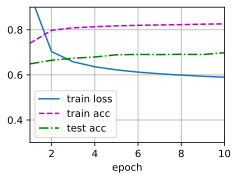

In [ ]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## Prediction

In [ ]:
def predict_ch3(net, test_iter, n = 6):
  """Predict labels (defined in Chapter 3)."""
  for X, y in test_iter:
    break
  trues = get_KMNIST_labels(y)
  preds = get_KMNIST_labels(net(X).argmax(axis = 1))
  titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
  d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles = titles[0:n])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


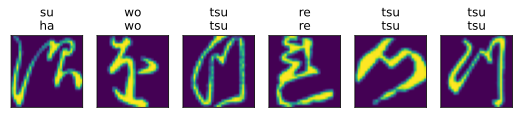

In [ ]:
predict_ch3(net, test_iter)

하나 틀렸다

# Concise Implementation of Softmax Regression

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
batch_size = 256
train_iter, test_iter = load_data_KMNIST(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Initializing Model Parameters

In [ ]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init__weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std = 0.01)

net.apply(init__weights);

## Softmax Implementation Revisited

In [ ]:
loss = nn.CrossEntropyLoss(reduction = "none")

## Optimization Algorithm

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr = 0.1)

## Training

AssertionError: ignored

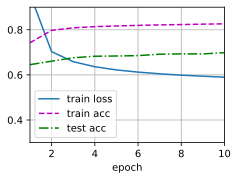

In [ ]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)